In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools

In [39]:
# Define the dataset path
dataset_path = '/Users/advait/Desktop/Knee_Arthiritis_AI/data'

In [41]:
# Get the list of categories
categories = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
data = []

In [43]:
# Collect data information
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith(".png"):
            data.append((category, filename))

In [45]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['Category', 'Filename'])
print(df.head())
print(df['Category'].value_counts())

  Category            Filename
0  0Normal  NormalG0 (166).png
1  0Normal  NormalG0 (189).png
2  0Normal  NormalG0 (473).png
3  0Normal  NormalG0 (218).png
4  0Normal  NormalG0 (131).png
Category
0Normal      514
1Doubtful    477
2Mild        232
3Moderate    221
4Severe      206
Name: count, dtype: int64


In [47]:
# Encode the labels
label_encoder = LabelEncoder()
df['Encoded_Category'] = label_encoder.fit_transform(df['Category'])

In [49]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Encoded_Category'])

print(train_df.shape, test_df.shape)

(1320, 3) (330, 3)


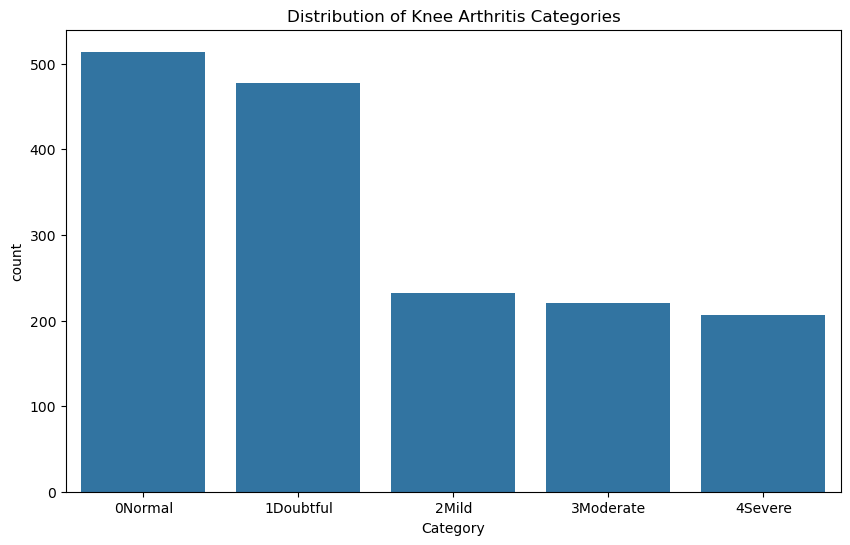

In [51]:
# Plot the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category')
plt.title('Distribution of Knee Arthritis Categories')
plt.show()

In [53]:
# Function to load and preprocess image
def load_and_preprocess_image(filepath):
    print(filepath)
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to a fixed size
    image = preprocess_input(image)  # Preprocess input for EfficientNetB0
    return image

In [55]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [57]:
# Prepare the data for training
def prepare_data(df, dataset_path):
    images = []
    labels = []
    for _, row in df.iterrows():
        filepath = os.path.join(dataset_path, row['Category'], row['Filename'])
        if filepath.endswith(".png"):
            image = load_and_preprocess_image(filepath)
            images.append(image)
            labels.append(row['Encoded_Category'])
    return np.array(images), np.array(labels)

train_images, train_labels = prepare_data(train_df, dataset_path)
test_images, test_labels = prepare_data(test_df, dataset_path)

/Users/advait/Desktop/Knee_Arthiritis_AI/data/2Mild/MildG2 (3).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/1Doubtful/DoubtfulG1 (381).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/3Moderate/ModerateG3 (35).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/0Normal/NormalG0 (197).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/1Doubtful/DoubtfulG1 (466).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/1Doubtful/DoubtfulG1 (327).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/0Normal/NormalG0 (307).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/0Normal/NormalG0 (259).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/0Normal/NormalG0 (211).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/0Normal/NormalG0 (200).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/1Doubtful/DoubtfulG1 (7).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/1Doubtful/DoubtfulG1 (477).png
/Users/advait/Desktop/Knee_Arthiritis_AI/data/3Moderate/ModerateG3 (160).png
/Users/advait/Desktop/Knee_Arthi

In [58]:
# Augment the training data
train_augmented_flow = datagen.flow(train_images, train_labels, batch_size=len(train_images), shuffle=False)
train_images_augmented, train_labels_augmented = next(train_augmented_flow)

In [60]:
# Concatenate the original and augmented data
train_images_augmented = np.concatenate([train_images, train_images_augmented])
train_labels_augmented = np.concatenate([train_labels, train_labels_augmented])

In [61]:
# Load the EfficientNetB0 model, excluding the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) ##### CHANGE THIS CODE TO CHANGE THE MODEL

In [65]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [67]:
# Add new top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [69]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [71]:
# Add learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [73]:
# Train the model
history = model.fit(train_images_augmented, train_labels_augmented, epochs=100, validation_data=(test_images, test_labels), callbacks=[lr_scheduler])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.5006 - loss: 1.2176 - val_accuracy: 0.4333 - val_loss: 2.3912 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.7176 - loss: 0.7167 - val_accuracy: 0.4121 - val_loss: 2.2581 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.8243 - loss: 0.4552 - val_accuracy: 0.6061 - val_loss: 1.1315 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.8669 - loss: 0.3653 - val_accuracy: 0.6727 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.8837 - loss: 0.3321 - val_accuracy: 0.7515 - val_loss: 1.0905 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.9201 - loss: 0.2119 - val_accuracy: 0.7182 - val_loss: 1.1963 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9183 - loss: 0.2223 - 

In [75]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc}')

11/11 - 8s - 727ms/step - accuracy: 0.8485 - loss: 0.9802
Test accuracy: 0.8484848737716675


In [77]:
# Generate predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 504ms/step


In [89]:
# Print classification report
print(classification_report(test_labels, predicted_classes, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

     0Normal       0.89      0.92      0.90       103
   1Doubtful       0.81      0.82      0.82        96
       2Mild       0.82      0.59      0.68        46
   3Moderate       0.95      0.89      0.92        44
     4Severe       0.77      0.98      0.86        41

    accuracy                           0.85       330
   macro avg       0.85      0.84      0.84       330
weighted avg       0.85      0.85      0.85       330



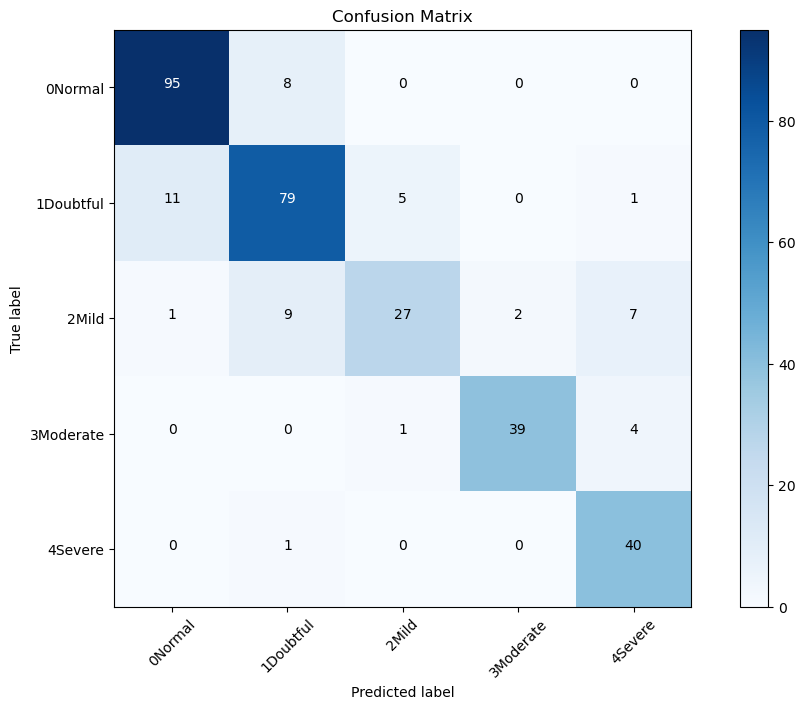

In [85]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plot_confusion_matrix(cm, classes=label_encoder.classes_)